In [2]:
import tensorflow as tf


In [3]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [4]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


2025-03-24 10:41:31.194651: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Chaining Transformations 

In [5]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


2025-03-24 10:41:31.209878: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
dataset = dataset.map(lambda x: x*2)
for i in dataset:
    print(i)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [7]:
dataset = dataset.apply(tf.data.experimental.unbatch())
for i in dataset:
    print(i)

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=

2025-03-24 10:41:31.266117: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
dataset = dataset.filter(lambda x: x<10)
for i in dataset:
    print(i)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


In [9]:
for i in dataset.take(3):
    print(i)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


Shuffling the Data

In [10]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5,seed=42).batch(7)
for i in dataset:
    print(i)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


interleaving lines from multiple Files

In [11]:
# extra code – fetches, splits and normalizes the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and saving it to 20 CSV files:

In [12]:
# extra code – split the dataset into 20 parts and save it to CSV files

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [13]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [14]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

In [15]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [16]:
n_readers = 5
dataset = filepath_dataset.interleave(
    
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

In [17]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)
tf.Tensor(b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625', shape=(), dtype=string)
tf.Tensor(b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526', shape=(), dtype=string)
tf.Tensor(b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442', shape=(), dtype=string)


2025-03-24 10:41:32.937129: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Preprocessing The Data

In [18]:
 #extra code – compute the mean and standard deviation of each feature

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)


StandardScaler()

In [19]:
X_mean , X_std =scaler.mean_,scaler.scale_
n_inputs = 8
def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [20]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

Putting Everything Together

to make the code reusuable , let's put together everything we have discussed so far into a small helper function. it will create and return a dataset that will efficiently load california housing data from multiple CSV files , then suffle it, preprocess it 

In [21]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [22]:
# extra code – show the first couple of batches produced by the dataset
example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.3957452  -0.04940685 -0.22830808  0.22648273  2.2593622   0.35200632
   0.9667386  -1.4121602 ]
 [ 2.7112627  -1.0778131   0.69413143 -0.14870553  0.51810503  0.3507294
  -0.82285154  0.80680597]
 [-0.13484643 -1.868895    0.01032507 -0.13787179 -0.12893449  0.03143518
   0.2687057   0.13212144]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.819]
 [3.674]
 [0.954]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.09031774  0.9789995   0.1327582  -0.13753782 -0.23388447  0.10211545
   0.97610843 -1.4121602 ]
 [ 0.05218809 -2.0271113   0.2940109  -0.02403445  0.16218767 -0.02844518
   1.4117942  -0.93737936]
 [-0.672276    0.02970133 -0.76922584 -0.15086786  0.4962024  -0.02741998
  -0.7853724   0.77182245]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.725]
 [1.205]
 [1.625]], shape=(3, 1), dtype=float32)



In [23]:
# extra code – list all methods of the tf.data.Dataset class
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● counter()            Creates a `Dataset` that counts from `start` in steps of size `step`.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● fingerprint()     

Using the dataset with Tf.keras

In [24]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [25]:
# extra code – for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [26]:
model  = tf.keras.Sequential([
    tf.keras.layers.Dense(30,activation="relu",kernel_initializer="he_normal",input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse",optimizer='sgd')
model.fit(train_set,validation_data= valid_set,epochs = 5)

Epoch 1/5


/opt/anaconda3/envs/Data_pytorcch/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4666 - val_loss: 87.7775
Epoch 2/5


/opt/anaconda3/envs/Data_pytorcch/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 2.8879 - val_loss: 1.3293
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 0.8705 - val_loss: 0.4237
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.4496 - val_loss: 0.3914
Epoch 5/5


2025-03-24 10:41:35.742477: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.4243 - val_loss: 0.3756


In [27]:
evaluation = model.evaluate(test_set)
new_set = test_set.take(3)
y_pred = model.predict(new_set)


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - loss: 0.4079
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Create a custom function that performs the whole training loop 
,First we need to create a custom training loop set up loss function and optimizer 

In [28]:
# defining loss function and optimizer for training 
optimizer = tf.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.losses.MeanSquaredError()

n_epochs =5
for epoch in range(n_epochs):
    for X_batch,y_batch in train_set:
        # extra code – perform one Gradient Descent step
        #              as explained in Chapter 12
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


Epoch 5/5

In [29]:
@tf.function
def train_one_epoch(model,optimizer,loss_fn,train_set):
    for X_batch,y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch,y_pred))
            loss = tf.add_n([main_loss]+model.losses)
        gradients = tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(gradients,model.trainable_variables))
optimizer = tf.optimizers.SGD(learning_rate = 0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
for epoch in range(n_epochs):
    print('\rEpoch {}/{}'.format(epoch+1,n_epochs),end="")
    train_one_epoch(model,optimizer,loss_fn,train_set)
            

Epoch 5/5

The TFRecord Format 

In [30]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [31]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [32]:
# extra code to show how to read extra file or read files parellel 
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


Compressed TFRecord Files

In [33]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord",options) as f:
    f.write(b"Compress, compress, compress!")
dataset  = tf.data.TFRecordDataset(["my_compressed.tfrecord"],compression_type="GZIP")
for record in dataset:
    print(record)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


A Brief Introduction to Protocol Buffers 

In [34]:
%%writefile person.proto
Syntax = "proto3";
message Person {
    string name =1;
    int32 id =2;
    repeated string email = 3;
}

Overwriting person.proto


In [35]:
%ls person*

person.proto


In [36]:
# to check how to use protobuf access in python 
from person_pb2 import Person
person = Person(name='manish',id=2111981114 ,email=["swamimanish927@gmail.com"])
print(person)

ModuleNotFoundError: No module named 'person_pb2'

Tensorflow Protobufs

syntax = "proto3"
message ByteList {repeated bytes value =1; }

message FloatList {repeated float value=1[packed = true];}

message IntList {repeated int64 value =1 [packed = true];}

message Feature{
    
    oneof kind {
        
        ByteList bytes_list =1;
        
        FloatList float_list =2;
        
        Int64List int64_list =3;
        
    }
    
};

message Features {map<string ,Feature> feature =1;};

message Example {Features features =1;};

In [37]:
from tensorflow.train import BytesList,FloatList,Int64List
from tensorflow.train import Feature , Features,Example

person_example = Example(
    features = Features(
        feature={
            "name":Feature(bytes_list = BytesList(value=[b"manish"])),
            "id":Feature(int64_list=Int64List(value=[2111981114])),
            "emails":Feature(bytes_list=BytesList(value=[b"abc@.com",
                                                         b"a@b.com"]))
        }))


In [38]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

Loading and Parsing Examples 

In [39]:
feature_description ={
    "name":tf.io.FixedLenFeature([],tf.string,default_value=""),
    "id":tf.io.FixedLenFeature([],tf.int64,default_value=0),
    "emails":tf.io.VarLenFeature(tf.string),
}
def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example,feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'abc@.com' b'a@b.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=2111981114>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'manish'>}


In [40]:
tf.sparse.to_dense(parsed_example["emails"],default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'abc@.com', b'a@b.com'], dtype=object)>

In [41]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'abc@.com', b'a@b.com'], dtype=object)>

In [42]:
def parse(serialized_example):
    return tf.io.parse_example(serialized_example,feature_description)
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'abc@.com' b'a@b.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([1 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2111981114])>, 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'manish'], dtype=object)>}


In [43]:
parsed_example

{'emails': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'abc@.com' b'a@b.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([1 2], shape=(2,), dtype=int64)),
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2111981114])>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'manish'], dtype=object)>}

Extra Material -Storing Images and Tensors in TFRecords

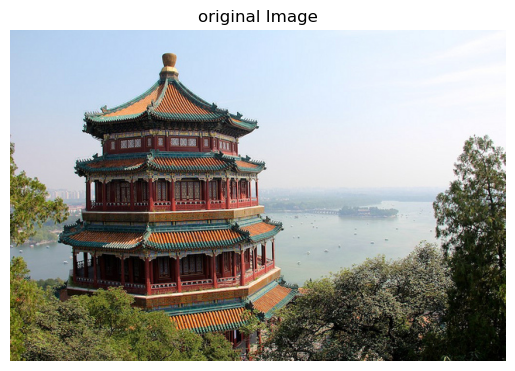

In [44]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("original Image")
plt.show()

Now lets Create a Example protobuf containg the image encoded as JPEG


In [45]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features  = Features(feature={
    "image":Feature(bytes_list = BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("my_image.tfrecord") as f:
    f.write(serialized_example)

Finally let's create a tf.data pipeline that will read this TFRecord file , parse each Example protobuf (in this case just one), and parse and display the image that the example contains 

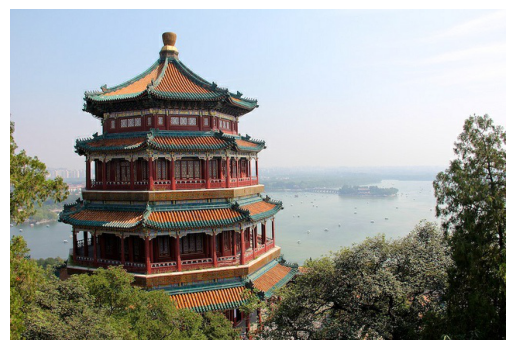

2025-03-24 10:42:14.495919: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [46]:
feature_description = {"image":tf.io.VarLenFeature(tf.string)}

def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example,feature_description)
    return tf.io.decode_jpeg(example_with_image["image"].values[0])

dataset  = tf.data.TFRecordDataset("my_image.tfrecord").map(parse)
for image in dataset:
    plt.imshow(image)
    plt.axis("off")
    plt.show()

Or use `decode_image()` which  supports BMP,GIF , JPEG and PNG formats 
Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`

In [47]:
tensor  = tf.constant([[0.,1.],[2.,3.],[4.,5.]])
serialized = tf.io.serialize_tensor(tensor)
serialized

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [48]:
tf.io.parse_tensor(serialized,out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [49]:
sparse_tensor = parsed_example["emails"]
serialized_sparse = tf.io.serialize_sparse(sparse_tensor)
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x02" \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x11\x08\x07abc@.coma@b.com',
       b'\x08\t\x12\x04\x12\x02\x08\x02"\x10\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [50]:
BytesList(value = serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\002\" \000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\021\010\007abc@.coma@b.com"
value: "\010\t\022\004\022\002\010\002\"\020\001\000\000\000\000\000\000\000\002\000\000\000\000\000\000\000"

Handling Lists of Lists Using the SequenceExample Protobuf 

``Sysntax  = "proto3;``
```
message FeatureList {reapeated Feature feature=1;};

message FeatureList {map<string,FeatureList> feature_list =1;};

message SequenceExample {
    
    Features context =1;

    FeatureLists feature_lists = 2;

};

In [51]:
from tensorflow.train import FeatureList , FeatureLists,SequenceExample 
context = Features(feature={
    "author_id":Feature(int64_list = Int64List(value=[123])),
    "title":Feature(bytes_list=BytesList(value=[b"a",b"desert",b"place",b"."])),
    "pub_date":Feature(int64_list=Int64List(value=[1623,12,25]))
    
})
content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]
def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))
    
content_features = [words_to_feature(sentence) for sentence in content]
comments_featues = [words_to_feature(comment) for comment in comments]

sequence_example = SequenceExample(
    context = context,
    feature_lists = FeatureLists(feature_list={
        "content":FeatureList(feature = content_features),
        "comments":FeatureList(feature=comments_featues)
    })
)

In [52]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "a"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [53]:
serialized_sequence_example = sequence_example.SerializePartialToString()

In [54]:
context_feature_descriptions = {
    "author_id":tf.io.FixedLenFeature([],tf.int64,default_value=0),
    "title":tf.io.VarLenFeature(tf.string),
    "pub_date":tf.io.FixedLenFeature([3],tf.int64,default_value=[0,0,0]),
}
sequence_feature_descriptions={
    "content":tf.io.VarLenFeature(tf.string),
    "comments":tf.io.VarLenFeature(tf.string),
}

In [55]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example,context_feature_descriptions,sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

In [56]:
parsed_context

{'title': SparseTensor(indices=tf.Tensor(
 [[0]
  [1]
  [2]
  [3]], shape=(4, 1), dtype=int64), values=tf.Tensor([b'a' b'desert' b'place' b'.'], shape=(4,), dtype=string), dense_shape=tf.Tensor([4], shape=(1,), dtype=int64)),
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>}

In [57]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'desert', b'place', b'.'], dtype=object)>

In [58]:
parsed_feature_lists

{'comments': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]
  [0 2]
  [0 3]
  [0 4]
  [0 5]
  [1 0]
  [1 1]
  [1 2]
  [1 3]
  [1 4]
  [1 5]
  [1 6]
  [1 7]], shape=(14, 2), dtype=int64), values=tf.Tensor(
 [b'When' b'the' b'hurlyburly' b"'s" b'done' b'.' b'When' b'the' b'battle'
  b"'s" b'lost' b'and' b'won' b'.'], shape=(14,), dtype=string), dense_shape=tf.Tensor([2 8], shape=(2,), dtype=int64)),
 'content': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]
  [0 2]
  [0 3]
  [0 4]
  [0 5]
  [0 6]
  [1 0]
  [1 1]
  [1 2]
  [1 3]
  [1 4]
  [1 5]
  [1 6]
  [1 7]
  [1 8]], shape=(16, 2), dtype=int64), values=tf.Tensor(
 [b'When' b'shall' b'we' b'three' b'meet' b'again' b'?' b'In' b'thunder'
  b',' b'lightning' b',' b'or' b'in' b'rain' b'?'], shape=(16,), dtype=string), dense_shape=tf.Tensor([2 9], shape=(2,), dtype=int64))}

In [59]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


## keras Preprocessing Layers 

### The `Normalization` layer

In [60]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train)
model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 4.5486 - val_loss: 0.9550
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 0.8254 - val_loss: 0.7279
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 0.6204 - val_loss: 0.6685
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.6009 - val_loss: 0.6539
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.5922 - val_loss: 0.6415


In [61]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [62]:
tf.random.set_seed(42)
model= tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled,y_train,epochs=5,
          validation_data=(X_valid_scaled,y_valid))

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 4.7834 - val_loss: 0.8590
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 0.8123 - val_loss: 0.7667
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 0.6451 - val_loss: 0.7004
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 0.6218 - val_loss: 0.6824
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.6086 - val_loss: 0.6651


### The Features API

In [63]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [64]:
age_mean , age_std  = X_mean[1],X_std[1]
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age",normalizer_fn=lambda x: (x-age_mean)/age_std)


In [65]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(median_income,boundaries=[1.5,3.,4.5,6])

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Categorical Features 

In [66]:
ocean_prox_vorab = ['<1H OCEAN','INLAND','ISLAND','NEAR BAY','NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list("ocean_proximity",ocean_prox_vorab)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [67]:
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    "city",hash_bucket_size=1000
)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Crossed Categorical Features

In [68]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age,boundaries=[-1.,-0.5,0.,0.5,1.]
)
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age,ocean_proximity],hash_bucket_size=100
)

Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.


Encoding Categorical Features Using One-Hot Vectors

In [69]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Encoding Categorical Features Using Embeddings 

In [70]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,dimension=2)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [ ]:
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5,output_dim=2)# input_dim is the range of input that we can pass from 0 to 5 , output_dim is the dimension of the vector
embedding_layer(np.array([2,4,2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.02405839,  0.04887166],
       [-0.02544584, -0.01914415],
       [ 0.02405839,  0.04887166]], dtype=float32)>

In [77]:
tf.random.set_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[],dtype=tf.string),
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.04035572,  0.04371292],
       [ 0.04992731,  0.03921077],
       [-0.04035572,  0.04371292]], dtype=float32)>

In [78]:
# extra code – set seeds and generates fake random data
# (feel free to load the real dataset if you prefer)
tf.random.set_seed(42)
np.random.seed(42)
X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000).astype(object)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000).astype(object)
y_valid = np.random.rand(2_000, 1)

num_input = tf.keras.layers.Input(shape=[8], name="num")
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
cat_embeddings = lookup_and_embed(cat_input) 
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                    validation_data=((X_valid_num, X_valid_cat), y_valid))

Epoch 1/5
192/313 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - loss: 0.3223

/opt/anaconda3/envs/Data_pytorcch/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['num', 'cat']. Received: the structure of inputs=('*', '*')
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 0.2775 - val_loss: 0.1346
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 0.1243 - val_loss: 0.1019
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 0.0978 - val_loss: 0.0899
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 0.0879 - val_loss: 0.0855
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.0842 - val_loss: 0.0838


In [79]:
# extra code – shows that the model can also be trained using a tf.data.Dataset
train_set = tf.data.Dataset.from_tensor_slices(
    ((X_train_num, X_train_cat), y_train)).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices(
    ((X_valid_num, X_valid_cat), y_valid)).batch(32)
history = model.fit(train_set, epochs=5,
                    validation_data=valid_set)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.0834 - val_loss: 0.0833
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.0829 - val_loss: 0.0831
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 0.0828 - val_loss: 0.0830
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 0.0827 - val_loss: 0.0829
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 0.0827 - val_loss: 0.0829


Text Preprocessing

In [81]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_data = tf.keras.layers.TextVectorization()
text_vec_data.adapt(train_data)
text_vec_data(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]])>